In [42]:
import numpy as np
import pandas as pd
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from more_itertools import set_partitions
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

Dataset of $j$-th client follows $D_j\sim (\theta_i,\epsilon_j^2)$.
The following code is to simulate:
- $\epsilon_j^2$: the amount of noise in the sampling process 
- $\theta_j$: the true mean of players

In [43]:
means_dist = stats.norm(loc = 0, scale = 1)
variance_dist = stats.beta(a=8, b=2, scale = 500/4)
print(means_dist.var())
print(variance_dist.mean())

1.0
100.0


In [44]:
# def calculate_error(n_list,i,mue=means_dist.var(),var=variance_dist.mean()):
#     n=n_list[i]
#     N = sum(n_list)
#     sumsquares = sum([nval**2 for nval in n_list]) - n**2 + (N-n)**2
#     # uniform
#     error= (mue/N + sumsquares * var/(N**2))
#     return error

Calculate the error of clients in a coalition structure

In [45]:
#Reference: [https://github.com/kpdonahue/model_sharing_games]
#Here is the function inspired by the above reference.
def calculate_means(var = means_dist.var(), mue = variance_dist.mean(), 
                    n_list = [10, 20, 30], w_best = False, w_list = [0.2, 0.4, 0.6], v_best = False,
                    v_mat = [[0.1, 0.6, 0.3], [0.2, 0.8, 0.0], [0.3, 0.5, 0.2]], fair=False,err_list=None, q=0):
    '''
    Calculate exact error for mean estimation.  

    Args:
        var: variance of true mean distributions
        mue: mean of true error distribution. 
        n_list: a list of length M (number of players) with the number of samples each has.
        w_best: boolean, if true, calculates error given optimal values for w
        w_list: if w_best is false, a list of w-weights (in [0, 1]) for coarse-grained federation.
        v_best: boolean, if true, calculates error given optimal values for v
        v_mat: a matrix (list of lists) of weights each player uses in fine-grained federation: the rows sum up 
               to 1.
    Returns:
        dataframe with average error for each player, for: local, uniform, coarse-grained, and fine-grained 
        federation.  
    '''
    # dataframe for storing error
    player_error = pd.DataFrame(data = 0.0, index = ['local', 'uniform', 'coarse', 'fine','fair'], 
                                columns = range(len(n_list)))
    N = sum(n_list)
    
    # for each player, calculate their true error 
    for j, n in enumerate(n_list):
        
        # local
        player_error.loc['local'][j] = mue/n
        
        sumsquares = sum([nval**2 for nval in n_list]) - n**2 + (N-n)**2
        
        # uniform
        player_error.loc['uniform'][j] = (mue/N + sumsquares * var/(N**2))
        
        # coarse-grained
        if w_best: 
            if len(n_list) == 1: # division by 0 issue if length 1 list - equivalent to local
                w_err = player_error.loc['local'][j]
            else:
                w_err = (mue * (N-n) + var * sumsquares)/((N-n)*N + n*var*sumsquares/mue)
        # else:
        #     w = w_list[j]
        #     w_err = mue * ( w**2/n + (1-w**2)/N) + ((1-w)**2/(N**2)) * sumsquares* var
            player_error.loc['coarse'][j] = w_err
        
        # fine-grained
        if v_best: 
            # calculate optimal v weights
            V_list = [var + mue/ni for ni in n_list]
            sum_inv = sum([1/Vi for Vi in V_list]) - 1/V_list[j]
            vjj = (1 + var * sum_inv)/(1 + V_list[j] * sum_inv)
            weights = [(V_list[j]-var)/(Vk * (1 + V_list[j]*sum_inv)) for Vk in V_list]
            weights[j] = vjj
            v_vec = pd.DataFrame(weights)
        # else:
        #     v_vec = pd.DataFrame(v_mat[j])
            
            player_error.loc['fine'][j] = (mue * (v_vec**2).T.dot(pd.DataFrame([1/nval for nval in n_list])) + 
                                        var * ((v_vec**2).sum() - v_vec.iloc[j]**2 + (1 - v_vec.iloc[j])**2))[0][0]
    # err_list=[player_error.loc['uniform'][j]  for j, n in enumerate(n_list)]                                
    # for j, n in enumerate(n_list):    
        if fair is True:
            v_vec = pd.DataFrame([ni*pow(err_i,q)/sum([ni*pow(err_i,q) for ni,err_i in zip(n_list,err_list)]) for ni,err_i in zip(n_list,err_list)])
            player_error.loc['fair'][j] = (mue * (v_vec**2).T.dot(pd.DataFrame([1/nval for nval in n_list])) + 
                                        var * ((v_vec**2).sum() - v_vec.iloc[j]**2 + (1 - v_vec.iloc[j])**2))[0][0]


    return player_error

Collect errors in all possible coalition structures

In [46]:
#Reference: [https://github.com/kpdonahue/model_sharing_games]
#Here is the function inspired by the above reference.
def calc_error_groups(var = means_dist.var(), mue = variance_dist.mean(), same_size = False, 
                n = 10, M = 5, n_list = [1, 2], fair=False, err_list=None, q=0):
    '''
    Calculates the errors that players experience, for all possible arrangements of players into groups. 
    Assumes optimal versions of coarse and fine federation are used. 
    
    Args:
        var: variance of mean parameter. 
        mue: mean of errors. 
        same_size: boolean, indicates whether all players are the same size (if so, runs faster). 
        n: if players are the same size, indicates the size
        M: if players are the same size, indicates the number of players
        n_list: if players differ in their size, provides a list of those sizes. 
        
    Returns: 
        tables with errors for every combination of players (uniform, coarse, and fine-grained federation), 
        as well as local learning.
        
    
    '''
    
    if same_size:
        # all players are interchangable
        n_list = [n for i in range(M)]
        comb = list(itertools.combinations_with_replacement([0,1], r=M))
    else: 
        # for combinations, the identity of player matters (not interchangable)
        # for example: [1, 0, 1] means a group made of 1st and 3rd players only
        comb = list(itertools.product([0,1], repeat = len(n_list)))
    
    string_list = ["".join(map(str, val)) for val in comb] # string to name groups
    err_uniform = pd.DataFrame(data = np.nan, 
                              index = string_list,
                              columns = ['n_' + str(i) + '_err' for i in n_list] )
    err_best_coarse = err_uniform.copy()
    err_best_fine = err_uniform.copy()
    err_fair=err_uniform.copy()
        
    for index, group in enumerate(comb):
        loca = "".join(map(str, group)) # group index
        if sum(group) > 0: # ignore group with no members
            
            # drop players not in this group
            temp_n = [n_list[i] for i in range(len(n_list)) if list(group)[i] == 1]
            
            # calculate error table and rename columns
            error_table = calculate_means(var = var, mue = mue, n_list = temp_n, w_best = False, v_best = False,fair=fair,err_list=err_list,q=q)
            error_table.columns = [i for i in range(len(n_list)) if list(group)[i] == 1]  
            
            # copy errors into correct tables
            for player in range(len(n_list)):
                if list(group)[player] ==1: # if player is participating in group
                    err_uniform.iloc[index, player] = error_table.loc['uniform', player]
                    err_best_coarse.iloc[index, player] = error_table.loc['coarse', player]
                    err_best_fine.iloc[index, player] = error_table.loc['fine', player]
                    err_fair.iloc[index, player] = error_table.loc['fair', player]
    
    local_error = calculate_means(var = var, mue = mue, n_list = n_list, w_best = False, 
                                  v_best = False).loc['local']
    
    err_uniform.dropna(how = 'all', inplace = True)
    err_best_coarse.dropna(how = 'all', inplace = True)
    err_best_fine.dropna(how = 'all', inplace = True)
    err_fair.dropna(how = 'all', inplace = True)
    

    return err_uniform, err_best_coarse, err_best_fine, err_fair,local_error

Calculate utility in ACFG

In [47]:
def calc_unity_groups(err_uniform=None,  same_size = False, 
            n = 10, M = 5, n_list = [1, 2], preference="selfish",friends=None,w=0.4,client_pre=None):
    if client_pre==None:
        client_pre=list(range(len(n_list)))
    if same_size:
        # all players are interchangable
        n_list = [n for i in range(M)]
        comb = list(itertools.combinations_with_replacement([0,1], r=M))
    else: 
        # for combinations, the identity of player matters (not interchangable)
        # for example: [1, 0, 1] means a group made of 1st and 3rd players only
        comb = list(itertools.product([0,1], repeat = len(n_list)))
    
    string_list = ["".join(map(str, val)) for val in comb] # string to name groups
    util_uniform = pd.DataFrame(data = np.nan, 
                              index = string_list,
                              columns = ['n_' + str(i) + '_err' for i in n_list] )
    util_uniform=copy.deepcopy(err_uniform)
    
    all_coalition = int('1' * len(n_list), 2)
    for index, row_name in enumerate(util_uniform.index):
        current_coalition= int(row_name, 2)
        complement_coalition = all_coalition - current_coalition
        complement_coalition = bin(complement_coalition)[2:]
        complement_coalition = complement_coalition.zfill(len(n_list))
        if sum([int(exist) for exist in complement_coalition])!=0:
            complement_index = util_uniform.index.get_loc(complement_coalition)
        else:
            complement_index=None
        
        # copy errors into correct tables
        for player in client_pre:
        # for player in range(len(n_list)):
            if list([exist for exist in row_name])[player]=="1": # if player is participating in group
                if preference=="mean-FR":
                    # if index=="00001":
                    #     print()
                    if complement_index!=None:
                        # print(err_uniform.iloc[index,player])
                        # print(pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]].replace("-", np.nan), errors='coerce'))
                        # print(pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce'))
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*(pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]].replace("-", np.nan), errors='coerce').sum(skipna=True)+pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').sum(skipna=True))/(len(friends[str(player)])+1)
                        # print( util_uniform.iloc[index, player])
                    else:
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]]).sum(skipna=True)/(len(friends[str(player)])+1)
                        
                if preference=="min-FR":
                    if complement_index!=None:
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*np.nanmax([pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]].replace("-", np.nan), errors='coerce').max(skipna=True),pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').max(skipna=True)])
                    else:
                        util_uniform.iloc[index, player] =w*err_uniform.iloc[index,player]+(1-w)*pd.to_numeric(err_uniform.iloc[index,friends[str(player)]+[player]]).max(skipna=True)
                if preference=="mean-PA": 
                    if complement_index!=None:
                        util_uniform.iloc[index, player] =(pd.to_numeric(err_uniform.iloc[index,friends[str(player)]].replace("-", np.nan), errors='coerce').sum(skipna=True)+pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').sum(skipna=True))/len(friends[str(player)])
                    else:
                        util_uniform.iloc[index, player] =pd.to_numeric(err_uniform.iloc[index,friends[str(player)]]).mean(skipna=True)        
                
                if preference=="min-PA":
                    if complement_index!=None:
                        util_uniform.iloc[index, player]=np.nanmax([pd.to_numeric(err_uniform.iloc[index,friends[str(player)]].replace("-", np.nan), errors='coerce').max(skipna=True),pd.to_numeric(err_uniform.iloc[complement_index,friends[str(player)]].replace("-", np.nan), errors='coerce').max(skipna=True)])
                    else:
                        util_uniform.iloc[index, player] =pd.to_numeric(err_uniform.iloc[index,friends[str(player)]]).max(skipna=True)
                             
    
    return util_uniform

Calculate utility in AHG

In [48]:
def calc_unity_groups_hedonic (err_uniform=None, var = means_dist.var(), mue = variance_dist.mean(), same_size = False, 
            n = 10, M = 5, n_list = [1, 2], preference="selfish",friends=None):
    
    if same_size:
        # all players are interchangable
        n_list = [n for i in range(M)]
        comb = list(itertools.combinations_with_replacement([0,1], r=M))
    else: 
        # for combinations, the identity of player matters (not interchangable)
        # for example: [1, 0, 1] means a group made of 1st and 3rd players only
        comb = list(itertools.product([0,1], repeat = len(n_list)))
    
    string_list = ["".join(map(str, val)) for val in comb] # string to name groups
    util_uniform = pd.DataFrame(data = np.nan, 
                              index = string_list,
                              columns = ['n_' + str(i) + '_err' for i in n_list] )
    util_uniform=copy.deepcopy(err_uniform)
    
    all_coalition = int('1' * len(n_list), 2)
    for index, row_name in enumerate(util_uniform.index):
        current_coalition= int(row_name, 2)
        complement_coalition = all_coalition - current_coalition
        complement_coalition = bin(complement_coalition)[2:]
        complement_coalition = complement_coalition.zfill(len(n_list))
        if sum([int(exist) for exist in complement_coalition])!=0:
            complement_index = util_uniform.index.get_loc(complement_coalition)
        else:
            complement_index=None
        
        # copy errors into correct tables
        # for player in [2]:
        for player in range(len(n_list)):
            friends_in_col=[i for i in friends[str(player)] if row_name[i]=="1"]
            if list([exist for exist in row_name])[player]=="1": # if player is participating in group
                
                if preference=="mean-FR":
                    util_uniform.iloc[index, player] =0.5*err_uniform.iloc[index,player]+0.5*pd.to_numeric(err_uniform.iloc[index,friends_in_col+[player]].replace("-", np.nan), errors='coerce').mean(skipna=True)
                        
                if preference=="min-FR":
                    util_uniform.iloc[index, player] =0.5*err_uniform.iloc[index,player]+0.5*pd.to_numeric(err_uniform.iloc[index,friends_in_col+[player]].replace("-", np.nan), errors='coerce').max(skipna=True)
                if preference=="mean-PA": 
                    util_uniform.iloc[index, player] =pd.to_numeric(err_uniform.iloc[index,friends_in_col].replace("-", np.nan), errors='coerce').mean(skipna=True)        
                
                if preference=="min-PA":
                    util_uniform.iloc[index, player] =pd.to_numeric(err_uniform.iloc[index,friends_in_col].replace("-", np.nan), errors='coerce').max(skipna=True)
                             
    
    return util_uniform

Check whether the grand coalition structure is stable? 

In [49]:
def check_stable(utility_uniform, utility_fair,structure):
    '''
    Check whether the grand coalition structure is stable
    
    Args:
        utility_uniform: Utility without considering fairness. 
        utility_fair: Utility  considering fairness. 
        structure:  all possible coalition structures
        
    Returns: 
        IF Stable? None/Subset
        
    
    '''
    row_ids = utility_uniform.index.tolist()
   
    grand_colition=row_ids[-1]
    grand_value=utility_fair.loc[grand_colition]
    for coalitions in structure:
        for coaltion in coalitions:
            not_nan_indices = utility_uniform.loc[coaltion].notna()

            check_less_equal = utility_uniform.loc[coaltion][not_nan_indices].le(grand_value[not_nan_indices])
            check_less = utility_uniform.loc[coaltion][not_nan_indices].lt(grand_value[not_nan_indices])

            all_columns_less_equal = check_less_equal.all()
            at_least_one_column_less = check_less.any()

            result = all_columns_less_equal and at_least_one_column_less

            if result:
                return coaltion
    return None

In [50]:
def check_same_position(str1, str2):
    for i in range(len(str1)):
        if str1[i] == '1' and str2[i] == '1':
            return 1
    return 0

def generate_combinations(numbers):
    target_decimal = pow(2,len(numbers[0]))-1 

    def backtrack(curr, idx,total):
        if total== target_decimal:
            combinations.append(curr)
            return
            
        exist=False
        if len(curr)!=0:
            for curr_i in curr:
                if check_same_position(curr_i,numbers[idx]):
                    exist=True
                
            
        if idx<len(numbers)-1:
            if exist==False:
                backtrack(curr+[numbers[idx]], idx + 1, total + int(numbers[idx], 2))
            backtrack(curr, idx + 1, total)
    combinations = []
    backtrack([], 0, 0)
    return combinations


In [51]:
clients_dataset_num = [20,40,50,100]
# clients_dataset_num = [1,5,10,15]

In [52]:
err_uniform, _, _, _,_ = calc_error_groups(n_list =clients_dataset_num)
err_uniform=err_uniform.replace([np.nan],['-'])
err_uniform

,n_20_err,n_40_err,n_50_err,n_100_err
0001,-,-,-,1.0
0010,-,-,2.0,-
0011,-,-,1.555556,0.888889
0100,-,2.5,-,-
0101,-,1.734694,-,0.877551
0110,-,1.728395,1.506173,-
0111,-,1.495845,1.390582,0.864266
1000,5.0,-,-,-
1001,2.222222,-,-,0.888889
1010,2.44898,-,1.591837,-


In [53]:
row_ids = err_uniform.index.tolist()
row_ids

['0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

Calculate Optimal Egalitarian Fairness Bound $\lambda$

In [54]:
def get_coalitions(n_list, s_list):
    coalitions = []
    for s in s_list:
        indices = [i for i, x in enumerate(s) if x == '1']
        coalitions.append(n_list[indices])
    return coalitions

Test 1. **Calculated egalitarian fairness bound** in Selfish Clients v.s. **Obtained egalitarian fairness**

In [55]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
for coalition in coalitions_except_grand:
    k = np.argmin(coalition)
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)
    lambdas_cal.append(max((N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)),1))
    
    
lambda_cal= max(lambdas_cal)
lambda_cal

1.614512471655329

In [56]:
err_list = err_uniform.iloc[-1].tolist()

q_list=np.arange(0,1,0.01).tolist()
lambda_list=[]
stable_list=[]


coalitions = generate_combinations(row_ids)

for q in q_list:
    err_uniform, _, _, err_fair,_ = calc_error_groups(n_list =clients_dataset_num,fair=True, err_list=err_list, q=q)
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])
    stable_result=check_stable(err_uniform,err_fair,coalitions)
    stable_list.append(stable_result!=None)

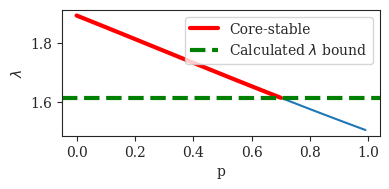

In [57]:

plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend()
plt.tight_layout()
plt.savefig("selfish_f.svg")
# plt.savefig("test_f.svg")
plt.show()

Test 2. **Calculated egalitarian fairness bound** in Purely Altruism v.s. **Obtained egalitarian fairness**

Full-connected Friendship

In [58]:
friends = {}
for i in range(len(clients_dataset_num)):
    friends[str(i)]=[]
    for j in range(len(clients_dataset_num)):
        if j!=i:
            friends[str(i)].append(j) 
w=0.3

In [59]:
# friends = {}
# for i in range(len(clients_dataset_num)):
#     friends[str(i)]=[]
#     friends[str(i)].append((i+1)%len(clients_dataset_num)) 
#     # friends[str(i)].append((i+2)%len(clients_dataset_num)) 
#     friends[str(i)].append((i-1)%len(clients_dataset_num) )
# friends

In [60]:
# friends ={'0': [1,1], '1': [0,3], '2': [3,3], '3': [1,2]}
# friends ={'0': [3,3], '1': [2,3], '2': [1,1], '3': [0,1]}
# friends ={'0': [3], '1': [2], '2': [1], '3': [0]}
# # wfriends ={'0': [3,2], '1': [2,2], '2': [0,1], '3': [0,0]}
# friends ={'0': [1,2,3], '1': [0,0,0], '2': [0,0,0], '3': [0,0,0]}
# friends ={'0': [1,2,2], '1': [0,3,3], '2': [0,0,0], '3': [1,1,1]}
# friends ={'0': [1,2], '1': [0,2], '2': [0,1], '3': [2,2]}
# w=0.3
# # w=0.1

In [61]:
# clients_dataset_array = np.array(clients_dataset_num)
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]
# friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
# friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

# for i,coalition in enumerate(coalitions_except_grand):
#     if row_ids[i]=="10000":
#         print()
#     # k=np.argmin(np.min(friends_num_array, axis=1))
#     # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

#     # if  row_ids[i][f_opt]=="1":
#     #     N_s=np.sum(coalition)
#     #     N_s_2_sum=np.sum(coalition**2)
#     # else:
#     #     N_s=N_g-np.sum(coalition)
#     #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
#     # k_list
#     c_in_c=[]
#     f_in_c=[]
#     f_in_c_num=[]
#     for j in range(len(row_ids[i])):
#         if row_ids[i][j]=="1":
#             c_in_c.append(j)
#             f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
#             # f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else float('inf') for f in friends[str(j)]])
#             f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
# )
#     f_in_c=np.array(f_in_c)
#     f_in_c_num=np.array(f_in_c_num)
#     k = np.argmin(np.min(f_in_c_num, axis=1))
#     # f_opt=f_in_c[k,np.argmin(f_in_c_num[k])]
#     f_opt=friends_array[c_in_c[k],np.argmin(friends_num_array[c_in_c[k]])]
#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
    
#     if row_ids[i][f_opt]=="0":
#         N_s=N_g-N_s
#         N_s_2_sum=N_g_2_sum-N_s_2_sum
#     if f_opt!=None:
#         lambdas_cal.append((N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f_opt]**2+(N_s-clients_dataset_array[f_opt])**2)))
        
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [62]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    # k=np.argmin(np.min(friends_num_array, axis=1))
    # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

    # if  row_ids[i][f_opt]=="1":
    #     N_s=np.sum(coalition)
    #     N_s_2_sum=np.sum(coalition**2)
    # else:
    #     N_s=N_g-np.sum(coalition)
    #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
    # k_list
    c_in_c=[]
    f_in_c=[]
    f_in_c_num=[]
    f_not_in_c=[]
    f_not_in_c_num=[]
    for j in range(len(row_ids[i])):
        if row_ids[i][j]=="1":
            c_in_c.append(j)
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else float('inf') for f in friends[str(j)]]))
            f_not_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='0' else float('inf') for f in friends[str(j)]]))
            # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])

    f_in_c=np.array(f_in_c)
    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c=np.array(f_not_in_c)
    f_not_in_c_num=np.array(f_not_in_c_num)
    k_1 = np.argmin(np.min(f_in_c_num, axis=1))
    k_2 = np.argmin(np.min(f_not_in_c_num, axis=1))
    # f_opt=f_in_c[k,np.argmin(f_in_c_num[k])]
    f_opt_1=f_in_c[k_1,np.argmin(f_in_c_num[k_1])]
    f_opt_2=f_not_in_c[k_2,np.argmin(f_not_in_c_num[k_2])]

    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

    lambda1=lambda2=float('inf')
    if f_opt_1!=None:
        lambda1=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f_opt_1]**2+(N_s-clients_dataset_array[f_opt_1])**2))
    if f_opt_2!=None:
        lambda2=(Not_N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f_opt_2]**2+(Not_N_s-clients_dataset_array[f_opt_2])**2))


    lambdas_cal.append(min(lambda1,lambda2))
        
lambda_cal= max(lambdas_cal) 
lambda_cal

1.079331485680692

In [63]:
# clients_dataset_array = np.array(clients_dataset_num)
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]

# for i,coalition in enumerate(coalitions_except_grand):
#     # k=np.argmin(np.min(friends_num_array, axis=1))
#     # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

#     # if  row_ids[i][f_opt]=="1":
#     #     N_s=np.sum(coalition)
#     #     N_s_2_sum=np.sum(coalition**2)
#     # else:
#     #     N_s=N_g-np.sum(coalition)
#     #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
#     # k_list
#     c_in_c=[]
#     f_in_c=[]
#     f_in_c_num=[]
#     f_not_in_c=[]
#     f_not_in_c_num=[]
#     for j in range(len(row_ids[i])):
#         if row_ids[i][j]=="1":
#             c_in_c.append(j)
#             f_in_c.append([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ])
#             f_not_in_c.append([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ])
#             f_in_c_num.append([clients_dataset_array[f] if row_ids[i][f]=='1' else float('inf') for f in friends[str(j)]])
#             f_not_in_c_num.append([clients_dataset_array[f] if row_ids[i][f]=='0' else float('inf') for f in friends[str(j)]])
#             # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])




#     k_1 = np.argmin(np.min(f_in_c_num, axis=1))
#     k_2 = np.argmin(np.min(f_not_in_c_num, axis=1))
#     # f_opt=f_in_c[k,np.argmin(f_in_c_num[k])]
#     f_opt_1=f_in_c[k_1][np.argmin(f_in_c_num[k_1])]
#     f_opt_2=f_not_in_c[k_2,np.argmin(f_not_in_c_num[k_2])]

#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
#     Not_N_s=N_g-N_s
#     Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

#     lambda1=lambda2=float('inf')
#     if f_opt_1!=None:
#         lambda1=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f_opt_1]**2+(N_s-clients_dataset_array[f_opt_1])**2))
#     if f_opt_2!=None:
#         lambda2=(Not_N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f_opt_2]**2+(Not_N_s-clients_dataset_array[f_opt_2])**2))


#     lambdas_cal.append(min(lambda1,lambda2))
        
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [64]:
#friends_list ={'0': [3], '1': [3], '2': [3], '3': [0,1,2]}
q_list=np.arange(0,4,0.05).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="min-PA",friends =friends)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="min-PA",friends =friends)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)

    print(err_fair)
    print(stable_result)
    print(util_uniform_ACFG_min_FR_i)
    print(max(err_list)/min(err_fair_last_row))

      n_20_err  n_40_err  n_50_err  n_100_err
0001       NaN       NaN       NaN   1.000000
0010       NaN       NaN  2.000000        NaN
0011       NaN       NaN  1.555556   0.888889
0100       NaN  2.500000       NaN        NaN
0101       NaN  1.734694       NaN   0.877551
0110       NaN  1.728395  1.506173        NaN
0111       NaN  1.495845  1.390582   0.864266
1000  5.000000       NaN       NaN        NaN
1001  2.222222       NaN       NaN   0.888889
1010  2.448980       NaN  1.591837        NaN
1011  1.799308       NaN  1.446367   0.858131
1100  2.555556  1.888889       NaN        NaN
1101  1.843750  1.593750       NaN   0.843750
1110  1.917355  1.553719  1.371901        NaN
1111  1.614512  1.424036  1.328798   0.852608
None
      n_20_err  n_40_err  n_50_err  n_100_err
0001       NaN       NaN       NaN   1.917355
0010       NaN       NaN  1.843750        NaN
0011       NaN       NaN  2.555556   2.555556
0100       NaN  1.799308       NaN        NaN
0101       NaN  2.448980     

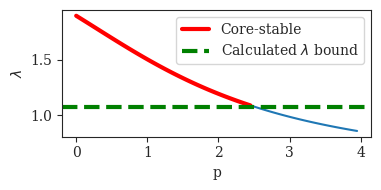

In [65]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend()
plt.tight_layout()
# plt.savefig("pwa_f.svg")
plt.savefig("pwa_f.svg")
plt.show()

Test 3. **Calculated egalitarian fairness bound** in Friendly Welfare Altruism v.s. **Obtained egalitarian fairness**

In [66]:
# clients_dataset_array = np.array(clients_dataset_num)
# grand_list=list(range(clients_dataset_array.shape[0]))
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]
# lambdas_cal_ref=[]
# friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
# friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

# for i,coalition in enumerate(coalitions_except_grand):
#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
#     Not_N_s=N_g-N_s
#     Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

#     c_in_s=[]
#     c_and_f_num=[]
#     c_and_f_not_num=[]
#     c_and_f_num_sum=[]
#     c_and_f_not_num_sum=[]
#     f_in_c=[]
#     for j in range(len(row_ids[i])):
#         if row_ids[i][j]=="1":
#             c_in_s.append(j)
#             c_and_f_num_sum_i=[float('inf') for c_i in range(len(clients_dataset_num))]

#             c_and_f_num_sum_i[j]=clients_dataset_array[j]
#             for f in friends[str(j)] :
#                 if row_ids[i][f]=='1':
#                     c_and_f_num_sum_i[f]=clients_dataset_array[f]
#                 else:
#                     c_and_f_num_sum_i[f]=float('inf')
#             c_and_f_num.append(np.array(c_and_f_num_sum_i))

#             if len([clients_dataset_array[f]/Not_N_s   for f in friends[str(j)] if row_ids[i][f]=='0' ])!=0:
#                 c_and_f_not_num_sum_i=[float('inf') for c_i in range(len(clients_dataset_num))]
#                 c_and_f_not_num_sum_i[j]=clients_dataset_array[j]
#                 for f in friends[str(j)] :
#                     if row_ids[i][f]=='0':
#                         c_and_f_not_num_sum_i[f]=clients_dataset_array[f]
#                     else:
#                         c_and_f_not_num_sum_i[f]=float('inf')
#                 c_and_f_not_num.append(np.array(c_and_f_not_num_sum_i))

#             c_and_f_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='1' ]))
#             # c_and_f_not_num_sum.append(w*clients_dataset_array[j]/N_s+(1-w)*min([clients_dataset_array[j]/N_s]+[clients_dataset_array[f]/Not_N_s   for f in friends[str(j)] if row_ids[i][f]=='0' ]))
#             if len([clients_dataset_array[f]/Not_N_s   for f in friends[str(j)] if row_ids[i][f]=='0' ])!=0:
#                 c_and_f_not_num_sum.append(w*clients_dataset_array[j]/N_s+(1-w)*min([clients_dataset_array[f]/Not_N_s   for f in friends[str(j)] if row_ids[i][f]=='0' ]))
#                 f_in_c.append(j)
#             # c_and_f_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='1' ]))
#             # c_and_f_not_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='0' ]))

#     # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
    
#     k1=np.argmin(np.array(c_and_f_num_sum))
#     f1=np.argmin(c_and_f_num[k1])
#     if len(c_and_f_not_num_sum)!=0:
#         k2=np.argmin(np.array(c_and_f_not_num_sum))
#         f2=np.argmin(c_and_f_not_num[k2])
#     if len(c_and_f_not_num_sum)==0:
#         lambda1=(N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((N_s*clients_dataset_array[l])+w*(N_s_2_sum-clients_dataset_array[c_in_s[k1]]**2+(N_s-clients_dataset_array[c_in_s[k1]])**2)+(1-w)*(N_s_2_sum-clients_dataset_array[f1]**2+(N_s-clients_dataset_array[f1])**2)))


#         lambda2=(N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((N_s*clients_dataset_array[l])+w*(N_s_2_sum-clients_dataset_array[c_in_s[k1]]**2+(N_s-clients_dataset_array[c_in_s[k1]])**2)+(1-w)*(N_s_2_sum-clients_dataset_array[f2]**2+(N_s-clients_dataset_array[f2])**2)))
#     # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
#     else:
#     # Not_N_s+=clients_dataset_array[c_in_s[k2]]
#     # Not_N_s_2_sum+=clients_dataset_array[c_in_s[k2]]**2
#         lambda1=(N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((N_s*clients_dataset_array[l])+w*(N_s_2_sum-clients_dataset_array[c_in_s[k1]]**2+(N_s-clients_dataset_array[c_in_s[k1]])**2)+(1-w)*(N_s_2_sum-clients_dataset_array[f1]**2+(N_s-clients_dataset_array[f1])**2)))


#         lambda2=(N_s**2*Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(Not_N_s**2*w*(N_s*clients_dataset_array[l]+(N_s_2_sum-clients_dataset_array[c_in_s[k2]]**2+(N_s-clients_dataset_array[c_in_s[k2]])**2))+N_s**2*(1-w)*(Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f2]**2+(Not_N_s-clients_dataset_array[f2])**2)))

    
#     lambdas_cal.append(min(lambda1,lambda2))
    
#     # not_coalition=[i for i in clients_dataset_array.tolist() if i not in coalition.tolist()]
#     # f1_ref=c_in_s.index(f1)
#     # c_not_in_s=[i for i in grand_list if i not in c_in_s]
#     # if f2 not in c_not_in_s:
#     #     f2_ref=c_in_s.index(f2)
#     #     lambda1_ref= w*calculate_error(coalition.tolist(),k1)+(1-w)*calculate_error(coalition.tolist(),f1_ref)
#     #     lambda2_ref= w*calculate_error(coalition.tolist(),k2)+(1-w)*calculate_error(coalition.tolist(),f2_ref)
#     # else:
#     #     f2_ref=c_not_in_s.index(f2)
#     #     lambda1_ref= w*calculate_error(coalition.tolist(),k1)+(1-w)*calculate_error(coalition.tolist(),f1_ref)
#     #     lambda2_ref= w*calculate_error(coalition.tolist(),k2)+(1-w)*calculate_error(not_coalition,f2_ref)
        
#     # all_error=calculate_error(clients_dataset_array.tolist(),m)
#     # lambdas_cal_ref.append(min(all_error/lambda1_ref,all_error/lambda2_ref))
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [67]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum

    c_in_s=[]
    c_and_f_num=[]
    c_and_f_not_num=[]
    c_and_f_num_sum=[]
    c_and_f_not_num_sum=[]

    for j in range(len(row_ids[i])):
        if row_ids[i][j]=="1":
            c_in_s.append(j)
            c_and_f_num_sum_i=[float('inf') for c_i in range(len(clients_dataset_num))]

            c_and_f_num_sum_i[j]=clients_dataset_array[j]
            for f in friends[str(j)] :
                if row_ids[i][f]=='1':
                    c_and_f_num_sum_i[f]=clients_dataset_array[f]
                else:
                    c_and_f_num_sum_i[f]=float('inf')
            c_and_f_num.append(np.array(c_and_f_num_sum_i))

        
            c_and_f_not_num_sum_i=[float('inf') for c_i in range(len(clients_dataset_num))]
            c_and_f_not_num_sum_i[j]=clients_dataset_array[j]
            for f in friends[str(j)] :
                if row_ids[i][f]=='0':
                    c_and_f_not_num_sum_i[f]=clients_dataset_array[f]
                else:
                    c_and_f_not_num_sum_i[f]=float('inf')
            c_and_f_not_num.append(np.array(c_and_f_not_num_sum_i))

            c_and_f_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='1' ]))
            c_and_f_not_num_sum.append(w*clients_dataset_array[j]/N_s+(1-w)*min([clients_dataset_array[j]/N_s]+[clients_dataset_array[f]/Not_N_s   for f in friends[str(j)] if row_ids[i][f]=='0' ]))
            
            # c_and_f_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='1' ]))
            # c_and_f_not_num_sum.append(w*clients_dataset_array[j]+(1-w)*min([clients_dataset_array[j]]+[clients_dataset_array[f]   for f in friends[str(j)] if row_ids[i][f]=='0' ]))

    # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
    
    k1=np.argmin(np.array(c_and_f_num_sum))
    k2=np.argmin(np.array(c_and_f_not_num_sum))

    f1=np.argmin(c_and_f_num[k1])
    f2=np.argmin(c_and_f_not_num[k2])
    # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
    lambda1=(N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((N_s*clients_dataset_array[l])+w*(N_s_2_sum-clients_dataset_array[c_in_s[k1]]**2+(N_s-clients_dataset_array[c_in_s[k1]])**2)+(1-w)*(N_s_2_sum-clients_dataset_array[f1]**2+(N_s-clients_dataset_array[f1])**2)))


    lambda2=(N_s**2*Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(Not_N_s**2*w*(N_s*clients_dataset_array[l]+(N_s_2_sum-clients_dataset_array[c_in_s[k2]]**2+(N_s-clients_dataset_array[c_in_s[k2]])**2))+N_s**2*(1-w)*(Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f2]**2+(Not_N_s-clients_dataset_array[f2])**2)))

    
    lambdas_cal.append(min(lambda1,lambda2))
        
lambda_cal= max(lambdas_cal) 
lambda_cal

0.9831706546064156

In [68]:
#friends_list ={'0': [3], '1': [3], '2': [3], '3': [0,1,2]}
q_list=np.arange(0,4,0.05).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="min-FR",friends =friends,w=w)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="min-FR",friends =friends,w=w)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)
    
    

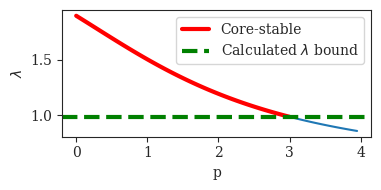

In [69]:

plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend()
plt.tight_layout()
plt.savefig("fwa_f.svg")
plt.show()

Test 4. **Calculated egalitarian fairness bound** in Purely Equal Altruism v.s. **Obtained egalitarian fairness**

In [70]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
    # k=np.argmin(np.min(friends_num_array, axis=1))
    # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

    # if  row_ids[i][f_opt]=="1":
    #     N_s=np.sum(coalition)
    #     N_s_2_sum=np.sum(coalition**2)
    # else:
    #     N_s=N_g-np.sum(coalition)
    #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
    # k_list
    f_in_c=[]
    f_num=[]
    f_all=[]
    f_in_c=[]
    f_not_in_c=[]
    f_in_c_num=[]
    f_not_in_c_num=[]
    f_stat=[]
    for j in range(len(row_ids[i])):
        if row_ids[i][j]=="1":
            f_stat.append([len(friends[str(j)])])
            f_all.append(np.array([f  for f in friends[str(j)] ]))
            f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ]))
            f_not_in_c_num.append(np.array([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]] ))
            # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
    f_stat=np.array(f_stat)
    f_all=np.array(f_all)
    f_num=np.array(f_num)
    f_in_c=np.array(f_in_c)
    f_not_in_c=np.array(f_not_in_c)
    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c_num=np.array(f_not_in_c_num)
    # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
    k=np.argmin(np.sum(f_in_c_num/N_s+f_not_in_c_num/Not_N_s,axis=1).reshape(-1,1)/f_stat.reshape(-1,1))
    
    # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
   

    f_k_num=len(f_all[k].tolist())
    sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k].tolist()  if f!=None])
    sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k].tolist() if f!=None ])
    
    lambda1=f_k_num*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*((Not_N_s**2)*sum_c_in_s+(N_s**2)*sum_c_not_in_s))
    
    lambdas_cal.append(lambda1)
        
lambda_cal= max(lambdas_cal) 
lambda_cal

1.2913714969000893

In [71]:
#friends_list ={'0': [3], '1': [3], '2': [3], '3': [0,1,2]}
q_list=np.arange(0,4,0.05).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="mean-PA",friends=friends)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="mean-PA",friends=friends)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)
    

    # if stable_result!=None:
    #     print()

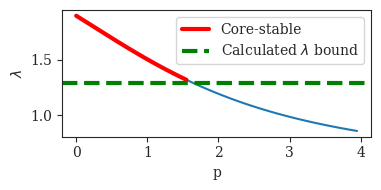

In [72]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
# fair_condition.append(len(fair_condition))
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend()
plt.tight_layout()
plt.savefig("pea_f.svg")
plt.show()

Test 5. **Calculated egalitarian fairness bound** in Friendly Equal Altruism v.s. **Obtained egalitarian fairness**

In [73]:
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
    # k=np.argmin(np.min(friends_num_array, axis=1))
    # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

    # if  row_ids[i][f_opt]=="1":
    #     N_s=np.sum(coalition)
    #     N_s_2_sum=np.sum(coalition**2)
    # else:
    #     N_s=N_g-np.sum(coalition)
    #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
    # k_list
    c_in_s=[]
    f_in_c=[]
    f_num=[]
    f_all=[]
    f_in_c=[]
    f_not_in_c=[]
    f_in_c_num=[]
    f_not_in_c_num=[]
    f_stat=[]
    for j in range(len(row_ids[i])):
        
        if row_ids[i][j]=="1":
            c_in_s.append(np.array([clients_dataset_num[j]]))
            f_all.append([f for f in friends[str(j)] ])
            f_stat.append([len(friends[str(j)])])
            f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array(sum([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ])))
            
            f_not_in_c_num.append(np.array(sum([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]]) ))

            # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
           
    c_in_s=np.array(c_in_s)
    f_stat=np.array(f_stat)

    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c_num=np.array(f_not_in_c_num)
    # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
    # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))

    k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+f_in_c_num.reshape(-1,1))/N_s+f_not_in_c_num.reshape(-1,1)/Not_N_s)/(f_stat+1))
    # print(k)
    # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
    # print(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
    # k=np.argmin(np.mean(f_in_c_num/N_s+f_not_in_c_num/Not_N_s, axis=1))
    # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
    f_k_num=len(f_all[k])
    sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k]  if f!=None])+(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)
    sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k] if f!=None ])
    
    lambda1=(f_k_num+1)*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(w*(f_k_num+1)*(Not_N_s**2)*(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)+(1-w)*(Not_N_s**2*sum_c_in_s+N_s**2*sum_c_not_in_s) ))
    
    lambda2=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2))
    lambdas_cal.append(lambda1)
lambda_cal= max(lambdas_cal) 
lambda_cal

1.220784309141039

In [74]:
# clients_dataset_array = np.array(clients_dataset_num)
# coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

# m = np.argmin(clients_dataset_array)
# l=np.argmax(clients_dataset_array)
# N_g=np.sum(clients_dataset_array)
# N_g_2_sum=np.sum(clients_dataset_array**2)
# lambdas_cal=[]
# friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
# friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

# for i,coalition in enumerate(coalitions_except_grand):
#     if row_ids[i]=="10001":
#             print()
#     N_s=np.sum(coalition)
#     N_s_2_sum=np.sum(coalition**2)  
#     Not_N_s=N_g-N_s
#     Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
#     # k=np.argmin(np.min(friends_num_array, axis=1))
#     # f_opt=friends_array[k,np.argmin(friends_num_array[k])]  

#     # if  row_ids[i][f_opt]=="1":
#     #     N_s=np.sum(coalition)
#     #     N_s_2_sum=np.sum(coalition**2)
#     # else:
#     #     N_s=N_g-np.sum(coalition)
#     #     N_s_2_sum=N_g_2_sum-np.sum(coalition**2)
#     # k_list
#     c_in_s=[]
#     f_in_c=[]
#     f_num=[]
#     f_all=[]
#     f_in_c=[]
#     f_not_in_c=[]
#     f_in_c_num=[]
#     f_not_in_c_num=[]
#     f_stat=[]
#     for j in range(len(row_ids[i])):
        
#         if row_ids[i][j]=="1":
#             c_in_s.append(np.array([clients_dataset_num[j]]))
#             f_all.append(np.array([f  for f in friends[str(j)] ]))
#             f_stat.append([len(friends[str(j)])])
#             f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
#             f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
#             f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
#             f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ]))
#             f_not_in_c_num.append(np.array([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]] ))
#             # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
#     c_in_s=np.array(c_in_s)
#     f_stat=np.array(f_stat)
#     f_all=np.array(f_all)
#     f_num=np.array(f_num)
#     f_in_c=np.array(f_in_c)
#     f_not_in_c=np.array(f_not_in_c)
#     f_in_c_num=np.array(f_in_c_num)
#     f_not_in_c_num=np.array(f_not_in_c_num)
#     t=f_not_in_c_num*(N_s)/(Not_N_s)
#     # k=np.argmin(np.mean(f_in_c_num+f_not_in_c_num*(N_s)/(Not_N_s), axis=1))
#     # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))
#     if row_ids[i]=="11110":
#         ttt=w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1)
#         k=np.argmax(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))
#     # k=np.argmin(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
#     # print(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1))/N_s+np.sum(f_not_in_c_num,axis=1)/Not_N_s)/(f_stat+1))
#     # k=np.argmin(np.mean(f_in_c_num/N_s+f_not_in_c_num/Not_N_s, axis=1))
#     # k = np.argmin(np.mean(f_in_c_num, axis=1)+np.mean(f_not_in_c_num, axis=1))
    
   

#         f_k_num=len(f_all[k].tolist())
#         sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k].tolist()  if f!=None])+(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[k]**2+(N_s-clients_dataset_array[k])**2)
#         sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k].tolist() if f!=None ])
        
#         lambda1=(f_k_num+1)*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(w*(f_k_num+1)*(Not_N_s**2)*(N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[k]**2+(N_s-clients_dataset_array[k])**2)+(1-w)*(Not_N_s**2*sum_c_in_s+N_s**2*sum_c_not_in_s) ))
        
#         lambdas_cal.append(lambda1)
# print(lambdas_cal)
# lambda_cal= max(lambdas_cal) 
# lambda_cal

In [75]:
#friends_list ={'0': [3], '1': [3], '2': [3], '3': [0,1,2]}

q_list=np.arange(0,4,0.05).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="mean-FR",friends=friends,w=w)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="mean-FR",friends=friends,w=w)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)
    
    

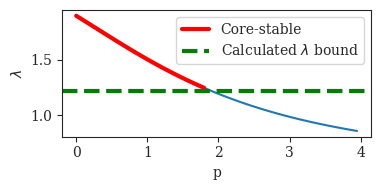

In [76]:
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend()
plt.tight_layout()
plt.savefig("fea_f.svg")
plt.show()

Test 6. **Calculated egalitarian fairness bound**  v.s. **Obtained egalitarian fairness** under multi-preferences

Case 1: 2 Selfish+3 Friendly Equal Altrusim

In [77]:
C=[2,3]

In [78]:
# selfish lambda
clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
for i,coalition in enumerate(coalitions_except_grand):
    coalition_group=[]
    for j, is_exist in enumerate(row_ids[i]) :
        index_k=0
        if is_exist=="1" :
            if   j in C:
                coalition_group.append(coalition.tolist()[index_k])
            index_k+=1
    if len(coalition_group)!=0:
        coalition_group=np.array(coalition_group)
        k = np.argmin(coalition_group)
        N_s=np.sum(coalition)
        N_s_2_sum=np.sum(coalition**2)
        lambdas_cal.append(max((N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition_group[k]**2+(N_s-coalition_group[k])**2)),1))
    
lambda_cal_selfish= max(lambdas_cal)
lambda_cal_selfish

1.614512471655329

In [79]:
C2=[item for item in list(range(len(clients_dataset_num))) if item not in C]

In [80]:

clients_dataset_array = np.array(clients_dataset_num)
coalitions_except_grand=get_coalitions(clients_dataset_array,row_ids[:-1])

m = np.argmin(clients_dataset_array)
l=np.argmax(clients_dataset_array)
N_g=np.sum(clients_dataset_array)
N_g_2_sum=np.sum(clients_dataset_array**2)
lambdas_cal=[]
friends_array=np.array([np.array(friends[str(i)]) for i in range(clients_dataset_array.shape[0])])
friends_num_array=np.array([np.array([clients_dataset_array[f] for f in friends[str(i)]]) for i in range(clients_dataset_array.shape[0])])

for i,coalition in enumerate(coalitions_except_grand):
    N_s=np.sum(coalition)
    N_s_2_sum=np.sum(coalition**2)  
    Not_N_s=N_g-N_s
    Not_N_s_2_sum=N_g_2_sum-N_s_2_sum
    c_in_s=[]
    c_in_s_index=[]
    f_in_c=[]
    f_num=[]
    f_all=[]
    f_in_c=[]
    f_not_in_c=[]
    f_in_c_num=[]
    f_not_in_c_num=[]
    f_stat=[]
    for j in range(len(row_ids[i])):  
        if row_ids[i][j]=="1":
            c_in_s_index.append(j)
            c_in_s.append(np.array([clients_dataset_num[j]]))
            f_all.append(np.array([f  for f in friends[str(j)] ]))
            f_stat.append([len(friends[str(j)])])
            f_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]]))
            f_in_c.append(np.array([f  if row_ids[i][f]=="1" else None for f in friends[str(j)] ]))
            f_not_in_c.append(np.array([f  if row_ids[i][f]=="0" else None for f in friends[str(j)] ]))
            f_in_c_num.append(np.array([clients_dataset_array[f] if row_ids[i][f]=='1' else 0  for f in friends[str(j)] ]))
            f_not_in_c_num.append(np.array([clients_dataset_array[f]  if row_ids[i][f]=='0' else 0 for f in friends[str(j)]] ))
            # f_in_c_num.append(np.array([clients_dataset_array[f]  for f in friends[str(j)]])
    c_in_s=np.array(c_in_s)
    f_stat=np.array(f_stat)
    f_all=np.array(f_all)
    f_num=np.array(f_num)
    f_in_c=np.array(f_in_c)
    f_not_in_c=np.array(f_not_in_c)
    f_in_c_num=np.array(f_in_c_num)
    f_not_in_c_num=np.array(f_not_in_c_num)
    t=f_not_in_c_num*(N_s)/(Not_N_s)
    
    # k_common_index=[client for client in c_in_s_index if client in C2]
    common_index=[client for client in range(len(c_in_s_index)) if c_in_s_index[client] in C2]
    
    if len(common_index)!=0:
        k_cal=(w*c_in_s/N_s+(1-w)*((c_in_s+np.sum(f_in_c_num,axis=1).reshape(-1,1))/N_s+np.sum(f_not_in_c_num,axis=1).reshape(-1,1)/Not_N_s)/(f_stat+1))[common_index]

        k=common_index[np.argmin(k_cal)]

        f_k_num=len(f_all[k].tolist())
        sum_c_in_s=sum([N_s*clients_dataset_array[l]+N_s_2_sum-clients_dataset_array[f]**2+(N_s-clients_dataset_array[f])**2 for f in f_in_c[k].tolist()  if f!=None])+(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)
        sum_c_not_in_s=sum([Not_N_s*clients_dataset_array[l]+Not_N_s_2_sum-clients_dataset_array[f]**2+(Not_N_s-clients_dataset_array[f])**2 for f in f_not_in_c[k].tolist() if f!=None ])
        
        lambda1=(f_k_num+1)*(N_s**2)*(Not_N_s**2)*(N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/((N_g**2)*(w*(f_k_num+1)*(Not_N_s**2)*(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2)+(1-w)*(Not_N_s**2*sum_c_in_s+N_s**2*sum_c_not_in_s) ))
        
        lambda2=(N_s**2/N_g**2)*((N_g*clients_dataset_array[l]+N_g_2_sum-clients_dataset_array[m]**2+(N_g-clients_dataset_array[m])**2)/(N_s*clients_dataset_array[l]+N_s_2_sum-coalition[k]**2+(N_s-coalition[k])**2))
        lambdas_cal.append(lambda1)
lambda_cal_fea= max(lambdas_cal) 
lambda_cal_fea

1.0105056721598076

In [81]:
lambda_cal=max(lambda_cal_selfish,lambda_cal_fea)

In [82]:
q_list=np.arange(0,4,0.05).tolist()
lambda_list=[]
stable_list=[]

coalitions = generate_combinations(row_ids)
err_uniform, _, _, _,_ = calc_error_groups( n_list = clients_dataset_array)
err_list = err_uniform.iloc[-1].tolist()
util_uniform_ACFG_min_FR=calc_unity_groups(err_uniform=err_uniform, n_list = clients_dataset_array, preference="mean-FR",friends=friends,client_pre=C2,w=w)
for q in q_list:
    _, _, _, err_fair,_ = calc_error_groups( n_list = clients_dataset_array,fair=True, err_list=err_list,q=q)
    util_uniform_ACFG_min_FR_i=calc_unity_groups(err_uniform=err_fair, n_list = clients_dataset_array, preference="mean-FR",friends=friends,client_pre=C2,w=w)
    
    err_fair_last_row=err_fair.iloc[-1]
    lambda_list.append(err_list[0]/err_fair_last_row[-1])

    stable_result=check_stable(util_uniform_ACFG_min_FR,util_uniform_ACFG_min_FR_i,coalitions)
    stable_list.append(stable_result!=None)
    
    # if stable_result!=None:
    #     print()

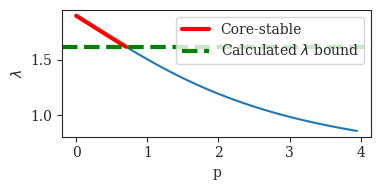

In [83]:
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times']
fig, ax = plt.subplots(figsize=(4,2))

ax.plot(q_list, lambda_list)

fair_condition = [index for index, element in enumerate(stable_list) if element == False]
ax.plot([q_list[i] for i in fair_condition] , [lambda_list[i] for i in fair_condition], color='red', linewidth=3, label='Core-stable')        
ax.axhline(y=lambda_cal, linewidth=3,color='green', linestyle='--',label='Calculated $\lambda$ bound')
plt.xlabel('p')
plt.ylabel('$\lambda$')
ax.legend()
plt.tight_layout()
plt.savefig("2_3_s_f.svg")
plt.show()